#Data Preprocessing

In [1]:
import cv2,os
data_path='C:/Users/dxlcshn/processed_images/train/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary
print(label_dict)
print(categories)
print(labels)

{'cataract': 0, 'normal': 1}
['cataract', 'normal']
[0, 1]


In [2]:
img_size=400
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:  
            resized=cv2.resize(img,(img_size,img_size))
            #resizing the image  into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

#Recale and assign  catagorical lables

In [3]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,3))
target=np.array(target)
from tensorflow.keras.utils import to_categorical
new_target = to_categorical(target)

In [5]:
new_target.shape

(491, 2)

#CNN Model

In [6]:
data.shape

(491, 400, 400, 3)

In [7]:
data.shape[1:]

(400, 400, 3)

Epoch 1/100


C:\Users\dxlcshn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5245 - loss: 0.6949 - val_accuracy: 0.4646 - val_loss: 0.7082
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4957 - loss: 0.7051 - val_accuracy: 0.4646 - val_loss: 0.6946
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4943 - loss: 0.6985 - val_accuracy: 0.4646 - val_loss: 0.6935
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5381 - loss: 0.6939 - val_accuracy: 0.4646 - val_loss: 0.6977


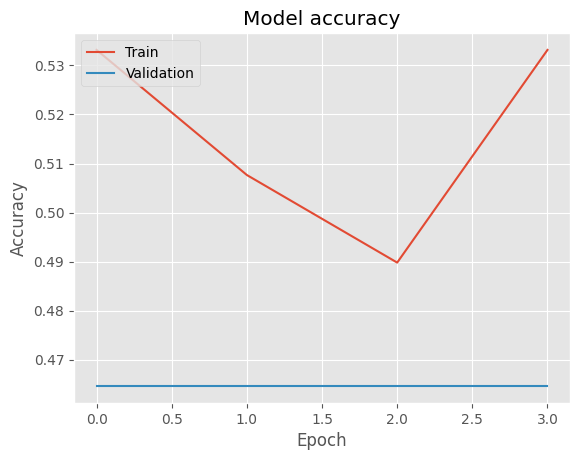

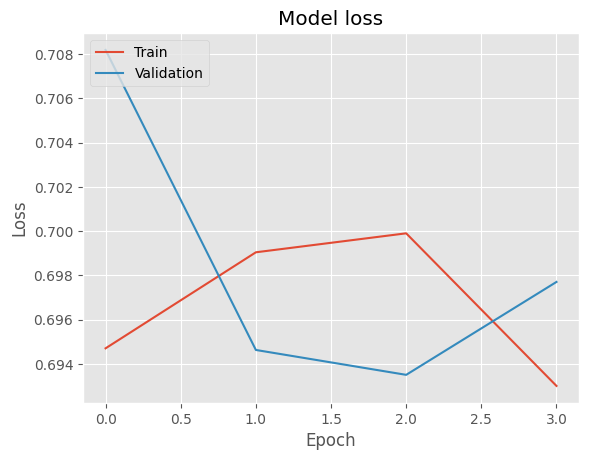

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Load pre-trained EfficientNetB0 model without top (include_top=False)
img_size = 400
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Add custom classification head with dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
predictions = Dense(2, activation='softmax')(x)  # Output layer with 2 units for binary classification

# Combine base model with custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Load and preprocess your data
# Assume data and new_target are already loaded and preprocessed

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, new_target, test_size=0.2, random_state=42)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
